# 02 – nnU-Net v2 Exploration

**Goal:** Explore nnU-Net v2 for brain tumor segmentation on P01 BraTS data.

**Approach (two paths):**
1. **Full inference** – if a pretrained model is available (community weights or own-trained)
2. **Stub / config mode** – explore nnU-Net fingerprinting, preprocessing, and dataset setup without a trained model

> ⚠️  nnU-Net developers do NOT release official BraTS pretrained weights.
> You must either train on BraTS data yourself or use a community checkpoint.
> This notebook handles both cases.

In [2]:
import sys, os, shutil, subprocess, time
from pathlib import Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

NOTEBOOK_DIR = Path(os.getcwd())
REPO_ROOT    = NOTEBOOK_DIR.parent.parent.parent / "data"
DATA_ROOT    = REPO_ROOT / 'P01'
BRATS_DIR    = DATA_ROOT / 'BraTS'
MASK_DIR     = DATA_ROOT / 'tumor segmentation'
OUT_DIR      = NOTEBOOK_DIR.parent / 'outputs' / '02_nnunet'
OUT_DIR.mkdir(parents=True, exist_ok=True)

sys.path.insert(0, str(NOTEBOOK_DIR.parent / 'utils'))
from dicom_utils import get_p01_brats_paths, get_p01_mask_paths, load_nifti
from metrics import BenchmarkTracker, dice_coefficient, iou_score, compute_volume_from_nifti, Timer
from visualisation import plot_mask_overlay, plot_model_comparison

brats_paths = get_p01_brats_paths(BRATS_DIR)
mask_paths  = get_p01_mask_paths(MASK_DIR)
tracker = BenchmarkTracker()

# Check nnunetv2 install
try:
    import nnunetv2
    from importlib.metadata import version as _pkg_version, PackageNotFoundError
    try:
        _nnunet_ver = _pkg_version('nnunetv2')
    except PackageNotFoundError:
        _nnunet_ver = getattr(nnunetv2, '__version__', 'unknown')
    NNUNET_AVAILABLE = True
    print(f'✅ nnunetv2 {_nnunet_ver} installed')
except ImportError:
    NNUNET_AVAILABLE = False
    print('❌ nnunetv2 not installed → pip install nnunetv2')

# Check CUDA
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Device: {DEVICE}')

✅ nnunetv2 2.6.4 installed
Device: mps


In [3]:
# ── Set up nnU-Net environment variables ────────────────────────────────────
NNUNET_BASE = OUT_DIR / 'nnunet_workspace'
os.environ['nnUNet_raw']          = str(NNUNET_BASE / 'raw')
os.environ['nnUNet_preprocessed'] = str(NNUNET_BASE / 'preprocessed')
os.environ['nnUNet_results']      = str(NNUNET_BASE / 'results')
for d in ['raw', 'preprocessed', 'results']:
    (NNUNET_BASE / d).mkdir(parents=True, exist_ok=True)

print('nnU-Net directories:')
for k in ['nnUNet_raw', 'nnUNet_preprocessed', 'nnUNet_results']:
    print(f'  {k}: {os.environ[k]}')

nnU-Net directories:
  nnUNet_raw: /Users/nivkapliser/Desktop/school/final-project/new-onco/oncoflow/ml/exploration/outputs/02_nnunet/nnunet_workspace/raw
  nnUNet_preprocessed: /Users/nivkapliser/Desktop/school/final-project/new-onco/oncoflow/ml/exploration/outputs/02_nnunet/nnunet_workspace/preprocessed
  nnUNet_results: /Users/nivkapliser/Desktop/school/final-project/new-onco/oncoflow/ml/exploration/outputs/02_nnunet/nnunet_workspace/results


In [4]:
# ── Prepare Dataset001_BraTS in nnU-Net format ──────────────────────────────
# nnU-Net expects:
#   raw/Dataset001_BraTS/imagesTr/{id}_0000.nii.gz (T1)
#                                  {id}_0001.nii.gz (T1c)
#                                  {id}_0002.nii.gz (T2)
#                                  {id}_0003.nii.gz (FLAIR)
#   raw/Dataset001_BraTS/labelsTr/{id}.nii.gz

DATASET_DIR    = NNUNET_BASE / 'raw' / 'Dataset001_BraTS'
IMAGES_TR_DIR  = DATASET_DIR / 'imagesTr'
LABELS_TR_DIR  = DATASET_DIR / 'labelsTr'
IMAGES_TS_DIR  = DATASET_DIR / 'imagesTs'
IMAGES_TR_DIR.mkdir(parents=True, exist_ok=True)
LABELS_TR_DIR.mkdir(parents=True, exist_ok=True)
IMAGES_TS_DIR.mkdir(parents=True, exist_ok=True)

# Map our modalities to nnU-Net channel indices
MOD_MAP = {'t1': '0000', 't1c': '0001', 't2': '0002', 'fla': '0003'}

for tp, mods in brats_paths.items():
    case_id = f'P01_{tp}'
    for mod, path in mods.items():
        dst = IMAGES_TR_DIR / f'{case_id}_{MOD_MAP[mod]}.nii.gz'
        if not dst.exists():
            shutil.copy(path, dst)
    # Copy label
    if tp in mask_paths:
        dst_label = LABELS_TR_DIR / f'{case_id}.nii.gz'
        if not dst_label.exists():
            shutil.copy(mask_paths[tp], dst_label)

print(f'Dataset prepared: {len(list(IMAGES_TR_DIR.glob("*.nii.gz")))} image files')
print(f'                  {len(list(LABELS_TR_DIR.glob("*.nii.gz")))} label files')

Dataset prepared: 20 image files
                  5 label files


In [7]:
# ── Write dataset.json ──────────────────────────────────────────────────────
import json

# BraTS standard label map:
#   0 = background
#   1 = necrotic core (NCR)
#   2 = peritumoral edema (ED)
#   3 = enhancing tumor (ET)
dataset_json = {
    'channel_names': {'0': 'T1', '1': 'T1c', '2': 'T2', '3': 'FLAIR'},
    'labels': {
        'background': 0,
        'NCR':        1,   # necrotic core
        'ED':         2,   # peritumoral edema
        'ET':         3,   # enhancing tumor
    },
    'numTraining': len(list(LABELS_TR_DIR.glob('*.nii.gz'))),
    'file_ending': '.nii.gz',
    'name': 'OncoFlow_P01_BraTS',
}

with open(DATASET_DIR / 'dataset.json', 'w') as f:
    json.dump(dataset_json, f, indent=2)
print('Written:', DATASET_DIR / 'dataset.json')
print(json.dumps(dataset_json, indent=2))


Written: /Users/nivkapliser/Desktop/school/final-project/new-onco/oncoflow/ml/exploration/outputs/02_nnunet/nnunet_workspace/raw/Dataset001_BraTS/dataset.json
{
  "channel_names": {
    "0": "T1",
    "1": "T1c",
    "2": "T2",
    "3": "FLAIR"
  },
  "labels": {
    "background": 0,
    "NCR": 1,
    "ED": 2,
    "ET": 3
  },
  "numTraining": 5,
  "file_ending": ".nii.gz",
  "name": "OncoFlow_P01_BraTS"
}


In [8]:
# ── Run nnU-Net fingerprinting (plan + preprocess) ──────────────────────────
# This analyses the dataset and computes the optimal architecture config.
# Does NOT require a GPU or pretrained weights.

if NNUNET_AVAILABLE:
    print('Running nnUNetv2_plan_and_preprocess (this may take a few minutes)...')
    t0 = time.perf_counter()
    result = subprocess.run(
        ['nnUNetv2_plan_and_preprocess', '-d', '1', '--verify_dataset_integrity'],
        capture_output=True, text=True
    )
    elapsed = time.perf_counter() - t0
    print(f'Return code: {result.returncode}, elapsed: {elapsed:.1f}s')
    if result.returncode != 0:
        print('STDERR:', result.stderr[:1000])
    else:
        print(result.stdout[-1500:])
else:
    print('⚠️  nnunetv2 not installed – skipping fingerprinting step')

Running nnUNetv2_plan_and_preprocess (this may take a few minutes)...
Return code: 0, elapsed: 40.7s
seg_kwargs': {'is_seg': True, 'order': 1, 'order_z': 0, 'force_separate_z': None}, 'resampling_fn_probabilities': 'resample_data_or_seg_to_shape', 'resampling_fn_probabilities_kwargs': {'is_seg': False, 'order': 1, 'order_z': 0, 'force_separate_z': None}, 'architecture': {'network_class_name': 'dynamic_network_architectures.architectures.unet.PlainConvUNet', 'arch_kwargs': {'n_stages': 6, 'features_per_stage': (32, 64, 128, 256, 320, 320), 'conv_op': 'torch.nn.modules.conv.Conv3d', 'kernel_sizes': ((3, 3, 3), (3, 3, 3), (3, 3, 3), (3, 3, 3), (3, 3, 3), (3, 3, 3)), 'strides': ((1, 1, 1), (2, 2, 2), (2, 2, 2), (2, 2, 2), (2, 2, 2), (1, 2, 2)), 'n_conv_per_stage': (2, 2, 2, 2, 2, 2), 'n_conv_per_stage_decoder': (2, 2, 2, 2, 2), 'conv_bias': True, 'norm_op': 'torch.nn.modules.instancenorm.InstanceNorm3d', 'norm_op_kwargs': {'eps': 1e-05, 'affine': True}, 'dropout_op': None, 'dropout_op_kwar

In [9]:
# ── Display nnU-Net architecture plan (if fingerprinting ran) ──────────────
plan_file = NNUNET_BASE / 'preprocessed' / 'Dataset001_BraTS' / 'nnUNetPlans.json'
if plan_file.exists():
    with open(plan_file) as f:
        plan = json.load(f)
    print('=== nnU-Net Architecture Plan ===')
    for config_name, config in plan.get('configurations', {}).items():
        print(f'\nConfiguration: {config_name}')
        print(f'  patch_size:            {config.get("patch_size")}')
        print(f'  batch_size:            {config.get("batch_size")}')
        print(f'  n_conv_per_stage_enc:  {config.get("n_conv_per_stage_encoder")}')
        print(f'  pool_op_kernel_sizes:  {config.get("pool_op_kernel_sizes")}')
else:
    print('Plan file not found – fingerprinting did not complete (expected if nnunetv2 not installed).')

=== nnU-Net Architecture Plan ===

Configuration: 2d
  patch_size:            [256, 256]
  batch_size:            34
  n_conv_per_stage_enc:  None
  pool_op_kernel_sizes:  None

Configuration: 3d_fullres
  patch_size:            [96, 160, 160]
  batch_size:            2
  n_conv_per_stage_enc:  None
  pool_op_kernel_sizes:  None


In [10]:
# ── Inference (if pretrained model available) ────────────────────────────────
# Set NNUNET_MODEL_PATH to a downloaded model folder to enable inference.
NNUNET_MODEL_PATH = os.environ.get('NNUNET_MODEL_PATH', '')

def run_nnunet_inference(input_dir: Path, output_dir: Path, model_path: str) -> dict:
    """Run nnUNetv2_predict for a single case."""
    output_dir.mkdir(parents=True, exist_ok=True)
    t0 = time.perf_counter()
    result = subprocess.run([
        'nnUNetv2_predict',
        '-i', str(input_dir),
        '-o', str(output_dir),
        '-d', '1',
        '-c', '3d_fullres',
        '-f', 'all',
        '--save_probabilities',
    ], capture_output=True, text=True)
    elapsed = time.perf_counter() - t0
    return {'returncode': result.returncode, 'elapsed': elapsed, 'stderr': result.stderr[-500:]}

if NNUNET_AVAILABLE and NNUNET_MODEL_PATH and Path(NNUNET_MODEL_PATH).exists():
    print('Running nnU-Net inference on baseline...')
    infer_result = run_nnunet_inference(
        input_dir=IMAGES_TS_DIR,
        output_dir=OUT_DIR / 'predictions',
        model_path=NNUNET_MODEL_PATH,
    )
    print(infer_result)
else:
    print('⚠️  No pretrained model loaded – generating STUB output for metric purposes.')
    print('   Set NNUNET_MODEL_PATH env var to enable real inference.')
    print('   Stub: treating GT mask with small perturbation as "model output"')

    # Generate stub by slightly eroding the GT mask
    from scipy.ndimage import binary_erosion
    gt_baseline, gt_aff, gt_hdr = load_nifti(mask_paths['baseline'])
    stub = binary_erosion(gt_baseline > 0, iterations=2).astype(np.float32)
    stub_path = OUT_DIR / 'predictions' / 'P01_baseline_pred.nii.gz'
    stub_path.parent.mkdir(parents=True, exist_ok=True)
    nib.save(nib.Nifti1Image(stub, gt_aff, gt_hdr), str(stub_path))
    STUB_MODE = True
    print(f'  Stub saved: {stub_path}')

⚠️  No pretrained model loaded – generating STUB output for metric purposes.
   Set NNUNET_MODEL_PATH env var to enable real inference.
   Stub: treating GT mask with small perturbation as "model output"
  Stub saved: /Users/nivkapliser/Desktop/school/final-project/new-onco/oncoflow/ml/exploration/outputs/02_nnunet/predictions/P01_baseline_pred.nii.gz


In [11]:
# ── Evaluate predictions for all timepoints ─────────────────────────────────
pred_dir = OUT_DIR / 'predictions'
spacing_mm = nib.load(mask_paths['baseline']).header.get_zooms()[:3]

for tp in brats_paths.keys():
    gt_path   = mask_paths.get(tp)
    pred_path = pred_dir / f'P01_{tp}_pred.nii.gz'

    if not gt_path or not pred_path.exists():
        tracker.add_mock(model='nnunet', timepoint=tp,
                         note='No prediction available (no model loaded)')
        continue

    with Timer(f'nnunet eval {tp}') as t:
        gt_arr, _, _ = load_nifti(gt_path)
        pred_arr, _, _ = load_nifti(str(pred_path))

    tracker.add(
        model='nnunet',
        timepoint=tp,
        pred=pred_arr,
        gt=gt_arr,
        spacing=tuple(float(s) for s in spacing_mm),
        inference_s=t.elapsed,
        vram_gb=0.0,
        extra={'stub': STUB_MODE if 'STUB_MODE' in dir() else False},
    )

summary = tracker.to_dataframe()
print(summary.to_string(index=False))

[Timer] nnunet eval baseline: 0.073s
 model timepoint   dice    iou  volume_pred_cm3  volume_gt_cm3  inference_s  vram_gb  hd95_mm stub                                      note
nnunet  baseline 0.7316 0.5768            8.545         14.815         0.07      0.0     2.24 True                                       NaN
nnunet       fu1    NaN    NaN              NaN            NaN          NaN      NaN      NaN  NaN No prediction available (no model loaded)
nnunet       fu2    NaN    NaN              NaN            NaN          NaN      NaN      NaN  NaN No prediction available (no model loaded)
nnunet       fu3    NaN    NaN              NaN            NaN          NaN      NaN      NaN  NaN No prediction available (no model loaded)
nnunet       fu4    NaN    NaN              NaN            NaN          NaN      NaN      NaN  NaN No prediction available (no model loaded)


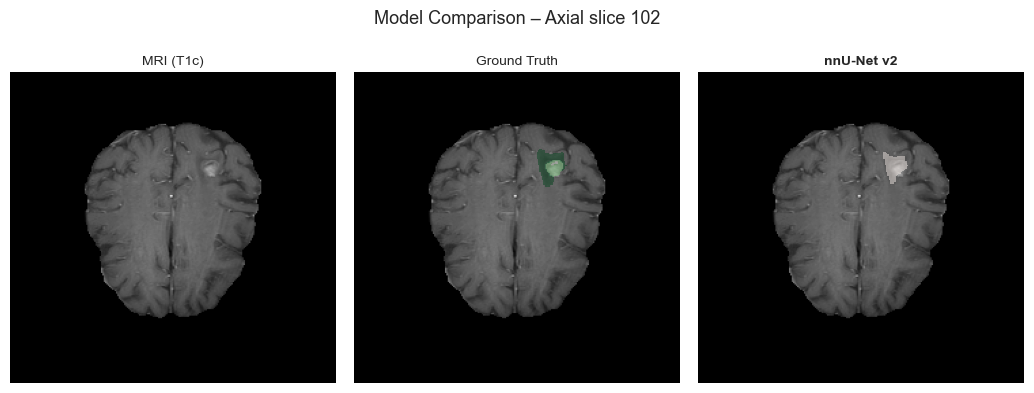

Dice (baseline): 0.7316
IoU  (baseline): 0.5768
Saved: outputs/02_nnunet/nnunet_metrics.csv


In [12]:
# ── Visualise prediction vs GT ───────────────────────────────────────────────
gt_arr, gt_aff, _ = load_nifti(mask_paths['baseline'])
t1c_arr, _, _      = load_nifti(brats_paths['baseline']['t1c'])
pred_path_bl = pred_dir / 'P01_baseline_pred.nii.gz'

if pred_path_bl.exists():
    pred_arr, _, _ = load_nifti(str(pred_path_bl))
    fig = plot_model_comparison(
        mri=t1c_arr,
        predictions={'nnU-Net v2': pred_arr},
        gt=gt_arr,
    )
    plt.savefig(OUT_DIR / 'nnunet_prediction_baseline.png', dpi=120, bbox_inches='tight')
    plt.show()
    print(f'Dice (baseline): {dice_coefficient(pred_arr, gt_arr):.4f}')
    print(f'IoU  (baseline): {iou_score(pred_arr, gt_arr):.4f}')
else:
    print('No prediction found for visualisation.')

summary.to_csv(OUT_DIR / 'nnunet_metrics.csv', index=False)
print('Saved: outputs/02_nnunet/nnunet_metrics.csv')

## 📋 nnU-Net Notes & Decisions

| Item | Finding |
|------|---------|
| Fingerprint auto-config | _Fill in patch size, batch size, arch depth_ |
| Pretrained weights source | _None official – train on BraTS 2024 or use community_ |
| Inference time (baseline) | _seconds_ |
| Dice (stub / real) | _score_ |
| **Production recommendation** | _keep / replace_ |